# Cropped Masked Autoencoders: Reconstruction Demo
Inspired by the [MAE Visualization Demo](https://colab.research.google.com/github/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb)

## Dependencies

In [177]:
!pip3 install -r "requirements.txt"
!pip3 install "gdown" # for downloading files from google drive

In [178]:
from matplotlib import pyplot as plt
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from PIL import Image
import numpy as np
import torch
import requests
import gdown

from models.SiamMAE import SIAM_MODELS
import misc.util as util
from data.util import GlobalToLocal, LocalToGlobal, RandomViews, SameViews

## Utils

In [179]:
def get_default_config():
    # We load the default configuration for CropMAE
    return util.get_args_parser().parse_known_args()[0]

def pil_to_tensor(pil_img):

    img = pil_img.resize((224, 224))
    img = np.array(img) / 255.

    # normalize by ImageNet mean and std
    img = img - np.array(IMAGENET_DEFAULT_MEAN)
    img = img / np.array(IMAGENET_DEFAULT_STD)

    return torch.tensor(img)

def show_image(image, title=''):
    assert image.shape[2] == 3 # image is [H, W, 3]
    plt.imshow(torch.clip((image * np.array(IMAGENET_DEFAULT_STD) + np.array(IMAGENET_DEFAULT_MEAN)) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def download_model_from_google_drive(path="https://drive.google.com/file/d/1RTkARjzkM9S3OO87AzVeDbYAF_b2zA-2/view?usp=sharing", name="cropmae_vits_16.pt"):
    # The default file corresponds to the vits-16 model used in the paper
    return gdown.download(path, name, quiet=False, fuzzy=True)


def prepare_model(chkpt_dir, backbone='vits_16'):
    model_size, patch_size = backbone.split('_')
    patch_size = int(patch_size)
    model = SIAM_MODELS[model_size](patch_size=patch_size)
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    status = model.load_state_dict(checkpoint['model'], strict=False)
    print(f"Model Loading Status: {status}")
    return model

def run_one_image(img, model, crop_strategy=GlobalToLocal):

    # Fetch default configuration
    default_conf = get_default_config()

    # Generate both views from the initial image
    v1, v2 = crop_strategy(default_conf)(img)
    v1 = v1.unsqueeze(0)
    v2 = v2.unsqueeze(0)
    v1v2 = torch.cat([v1, v2], dim=0).unsqueeze(0) # Batch-like

    # Run CropMAE
    loss, masked_preds, masked_masks = model(v1v2.float(), mask_ratio=0.985)
    
    rec_v2 = model.unpatchify(masked_preds[0])
    rec_v2 = torch.einsum('nchw->nhwc', rec_v2).detach().cpu()

    # visualize the mask
    mask_v2 = masked_masks[0].detach()
    mask_v2 = mask_v2.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask_v2 = model.unpatchify(mask_v2)  # 1 is removing, 0 is keeping
    mask_v2 = torch.einsum('nchw->nhwc', mask_v2).detach().cpu()
    
    v2 = torch.einsum('nchw->nhwc', v2)

    # masked image
    v2_masked = v2 * (1. - mask_v2)

    # MAE reconstruction pasted with visible patches
    im_paste = pil_to_tensor(img) * (1 - mask_v2) + rec_v2 * mask_v2

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [18, 18]

    print("Creation of the views:")
    plt.subplot(1, 3, 1)
    show_image(pil_to_tensor(img), "Original")

    plt.subplot(1, 3, 2)
    show_image(v1[0].permute(1, 2, 0), "V1")

    plt.subplot(1, 3, 3)
    show_image(v2[0], "V2")

    plt.tight_layout()
    plt.show()

    print("Reconstruction:")
    plt.subplot(1, 3, 1)
    show_image(v2_masked[0], "V2 Masked")

    plt.subplot(1, 3, 2)
    show_image(rec_v2[0], "V2 Reconstructed from V1")

    plt.subplot(1, 3, 3)
    show_image(im_paste[0], "V2 Reconstructed from V1 + Visible")

    plt.tight_layout()
    plt.show()

## Load Image

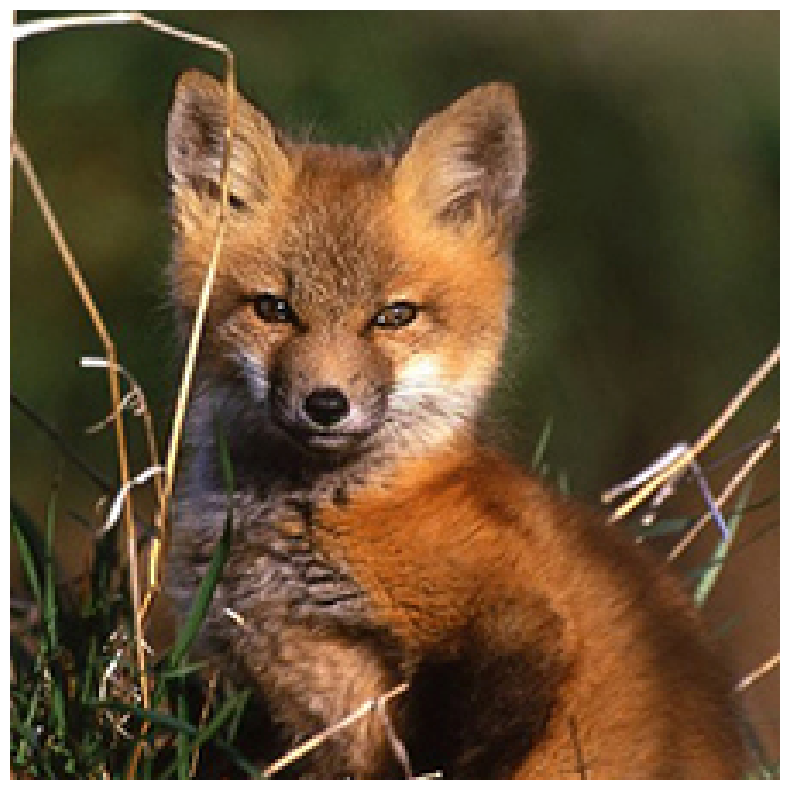

In [180]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
pil_img = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
img = pil_to_tensor(pil_img)

plt.rcParams['figure.figsize'] = [10, 10]
show_image(img)

## Load pre-trained Model

**NOTE:** The default model used was trained to predict the **normalized** pixel values, so the reconstructions will not look as good as the ones in the paper. We will release the models trained to predict the non-normalized pixel values soon for better visualization.

In [181]:
#model_local_path = download_model_from_google_drive()
#model = prepare_model(model_local_path, 'vits_16')

## Run CropMAE
CropMAE works by creating two views $V_1, V_2$ from an input image $I$ by following a particular cropping strategy (refer to the paper).

The second view $V_2$ is masked at a very high ratio, typically 98.5%, and reconstructed by the network, which has access to $V_1$ to do so.

Creation of the views:


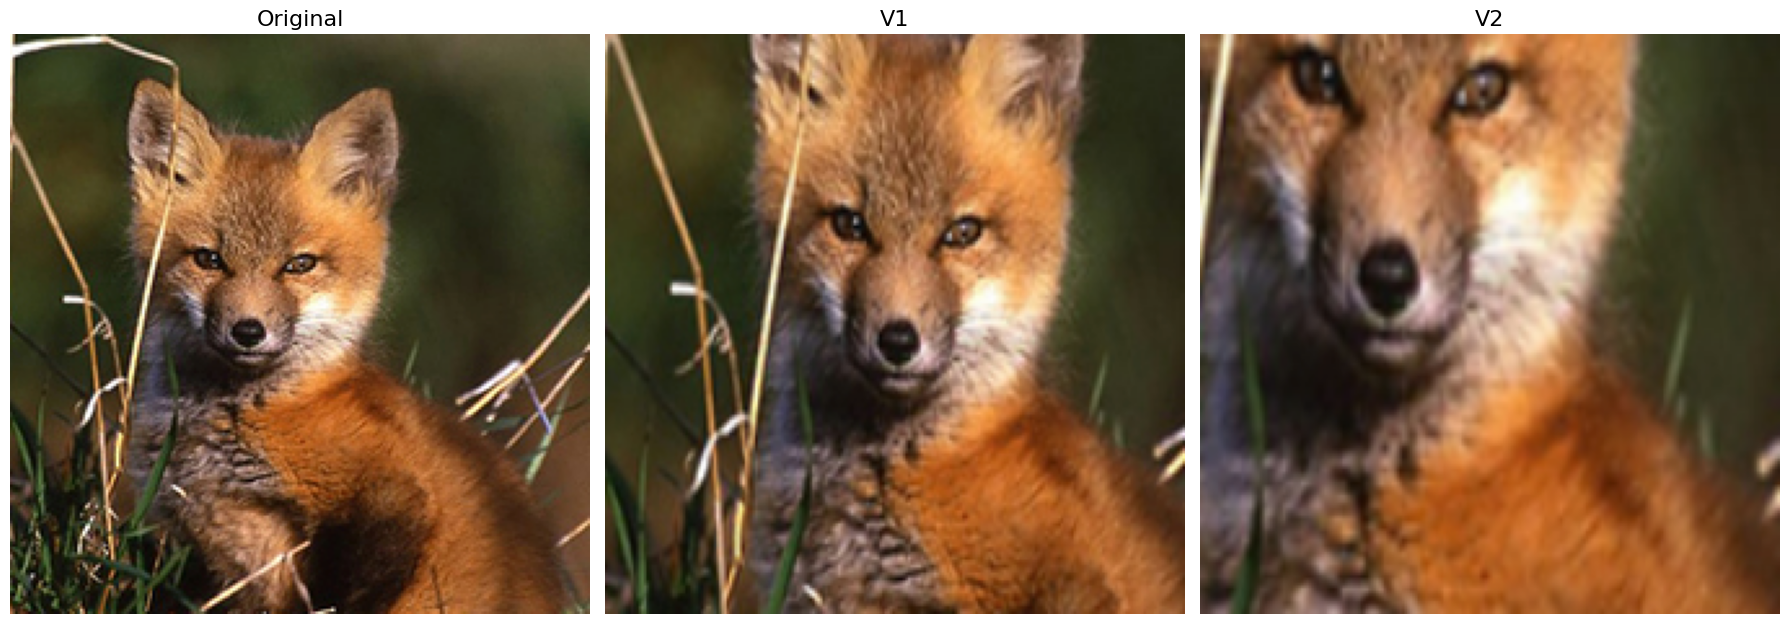

Reconstruction:


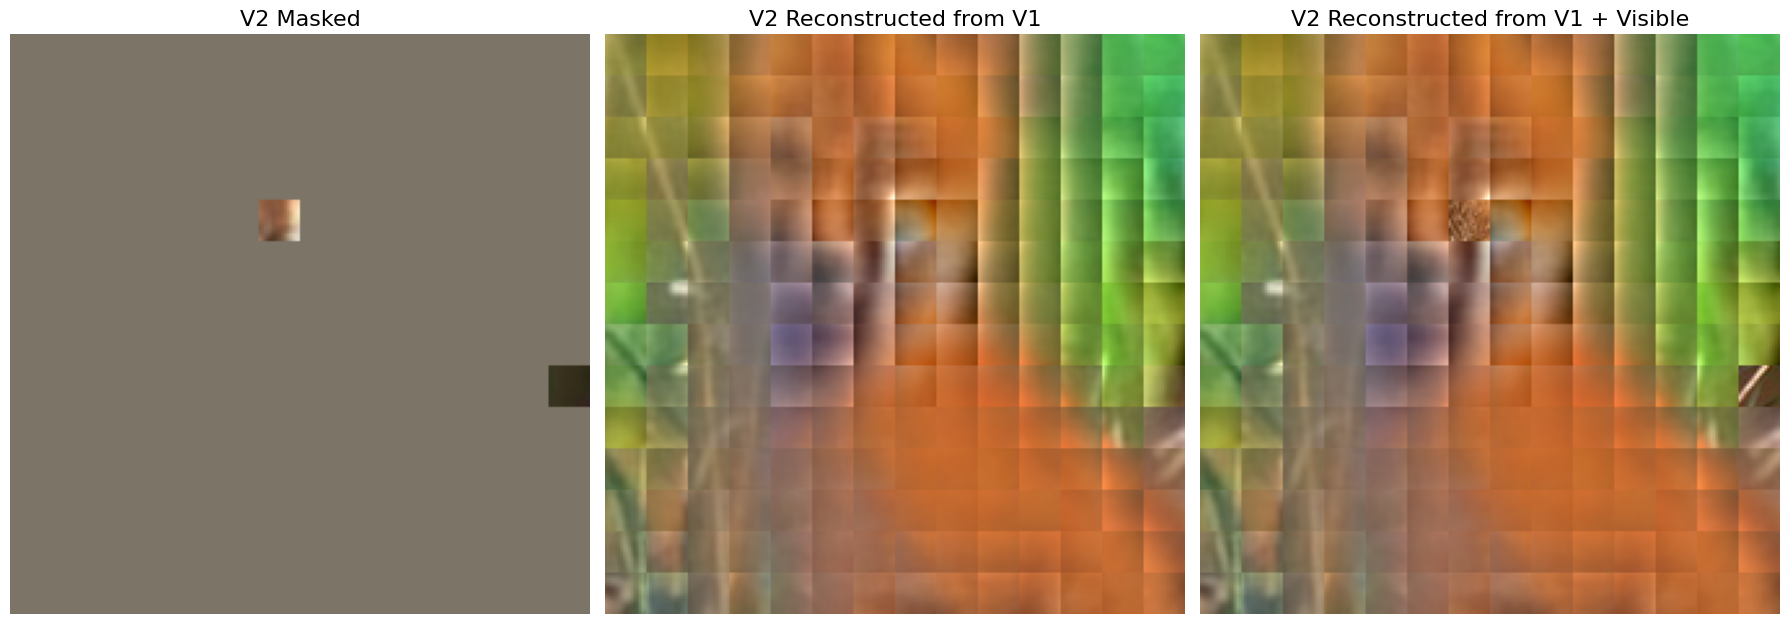

In [182]:
# Make random mask reproducible (comment out to make it change)
torch.manual_seed(42)
run_one_image(pil_img, model)